# Celebrity Look a Like CNN DL Project

#### Mohamed Youssef - 211001821


## Index


-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading & Cleaning the Data](#dataset)
    - [Reading Meta Data](#metadata)
    - [Creating Data Frame](#dataframe)
    - [Data Cleaning](#clean)
    <br>
-   [Visualization](#vis)
    -   [Univariate Exploration](#univis)
    -   [Bivariate Exploration](#bivis)
    <br>
-   [Preprocessing Data](#pre)
    -   [Getting Image Pixels](#pix)
    -   [Normalizing the Images](#norm)


## Including Necessary Librariess<a id='libs'></a>


In [1]:
# Disabling warnings
import warnings


def warn(*args, **kwargs):
    pass


warnings.warn = warn

In [2]:
# Python built-in libraries
from datetime import datetime, timedelta
import time
import os

# Other libraries
import chime

# Libraries for preprocessing and visualizing the data
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# OpenCV library for image processing
import cv2

# Tensorflow and Keras libraries for deep learning models
import tensorflow as tf

import keras
from keras.utils import img_to_array
import keras.utils as image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import (
    Dense,
    Activation,
    Dropout,
    Flatten,
    Input,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
    Activation,
)
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json


# Sklearn train test split function
from sklearn.model_selection import train_test_split

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the current directory
dataset_path = "C:/Data Sets/CLA Dataset"
print("Dataset path is: " + dataset_path)

Dataset path is: C:/Data Sets/CLA Dataset


In [4]:
# Configuring the GPU for training the model
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("Num GPUs Available: ", gpus)

    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU Available")

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Initializing chime
chime.theme("mario")
chime.notify_exceptions()

In [6]:
# Check if the user wants to download the dataset
download_dataset = False

In [7]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_dataset == False:
    raise SystemExit("Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.")
    
!wget -P "{dataset_path}" https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

SystemExit: Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.

C:\Users\Momad\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# Extracting the dataset from the tar file
if download_dataset == False:
    raise SystemExit("Dataset not extracted. Please extract the dataset, if you already have extracted the dataset ignore this message.")
    
!tar -xvf "{dataset_path}"/imdb_crop.tar -C "{dataset_path}"/imdb_crop

SystemExit: Dataset not extracted. Please extract the dataset, if you already have extracted the dataset ignore this message.

## Loading & Cleaning the Data <a id='dataset'></a>


### Reading Meta Data <a id='metadata'></a>


In [9]:
# Loading the mat file containing the data
data_mat = scipy.io.loadmat(dataset_path + "/imdb_crop/imdb_crop/imdb.mat")

In [10]:
# Getting the total number of records in the data
records = data_mat["imdb"][0][0][0].shape[1]
print("Total no. of records:", records)

Total no. of records: 460723


In [11]:
# Getting the column names of the data
features = data_mat["imdb"][0][0].dtype
features = list(features.names)
print("Total no. of features:", len(features))

Total no. of features: 10


In [12]:
# Rename the columns of the data
print("Current Features Names:\n", features)
features[0] = "Date of Birth"
features[1] = "Photo Taken Date"
features[2] = "Full Img Path"
features[3] = "Gender"
features[4] = "Celebrity Name"
features[5] = "Face Location"
features[6] = "Face Score"
features[7] = "Second Face Score"
features[8] = "Celeb Names"
features[9] = "Celeb ID"
print("New Features Names:\n", features)

Current Features Names:
 ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score', 'celeb_names', 'celeb_id']
New Features Names:
 ['Date of Birth', 'Photo Taken Date', 'Full Img Path', 'Gender', 'Celebrity Name', 'Face Location', 'Face Score', 'Second Face Score', 'Celeb Names', 'Celeb ID']


### Creating Data Frame <a id='dataframe'></a>


In [13]:
# Creating a dataframe to store the data
data_df = pd.DataFrame(index=(range(0, records)), columns=features)

In [14]:
# Extracting the data from the mat file and storing it in a dataframe
for i in data_mat:
    if i == "imdb":
        current_array = data_mat[i][0][0]
        for j in range(len(current_array)):
            data_df[features[j]] = pd.DataFrame(current_array[j][0])

In [15]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Date of Birth,Photo Taken Date,Full Img Path,Gender,Celebrity Name,Face Location,Face Score,Second Face Score,Celeb Names,Celeb ID
23161,718603,2004,[73/nm0000173_rm941722624_1967-6-20_2004.jpg],0.0,[Nicole Kidman],"[[905.4211447170281, 284.3521077240713, 1072.7...",3.750365,NaN,NaN,14588
92827,716357,2004,[40/nm0001040_rm1205377024_1961-4-26_2004.jpg],0.0,[Joan Chen],"[[50.88242187509365, 39.692994791739494, 100.7...",4.547499,4.204048,NaN,9247
62999,716254,1989,[06/nm0000506_rm2074777856_1961-1-13_1989.jpg],0.0,[Julia Louis-Dreyfus],"[[1, 1, 553, 450]]",-inf,NaN,NaN,10216
113607,717372,2010,[73/nm0001473_rm3494960896_1964-2-5_2010.jpg],0.0,[Laura Linney],"[[326.20226415154644, 285.6669811326031, 689.0...",2.347514,2.120739,NaN,11490
447980,725839,2015,[37/nm2395937_rm2480404224_1987-4-12_2015.jpg],0.0,[Brooklyn Decker],"[[708.0354523885087, 264.27191088716035, 887.5...",3.904888,NaN,NaN,2650


In [16]:
# Describing the data
data_df.describe()

,Date of Birth,Photo Taken Date,Gender,Face Score,Second Face Score,Celeb ID
count,460723.000000,460723.000000,452261.000000,4.607230e+05,213797.000000,460723.000000
mean,718987.731774,2005.461555,0.581996,-inf,2.452904,10116.802404
std,13253.963535,9.054475,0.493231,NaN,1.064432,5742.153266
min,47.000000,1961.000000,0.000000,-inf,0.730926,1.000000
25%,716370.000000,2004.000000,0.000000,1.757891e+00,1.583692,5294.000000
50%,719935.000000,2008.000000,1.000000,2.980097e+00,2.355163,10066.000000
75%,723073.000000,2011.000000,1.000000,4.006376e+00,3.228071,14922.000000
max,734963.000000,2015.000000,1.000000,7.381689e+00,6.395435,20284.000000


In [17]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of Birth      460723 non-null  int32  
 1   Photo Taken Date   460723 non-null  uint16 
 2   Full Img Path      460723 non-null  object 
 3   Gender             452261 non-null  float64
 4   Celebrity Name     460723 non-null  object 
 5   Face Location      460723 non-null  object 
 6   Face Score         460723 non-null  float64
 7   Second Face Score  213797 non-null  float64
 8   Celeb Names        20284 non-null   object 
 9   Celeb ID           460723 non-null  uint16 
dtypes: float64(3), int32(1), object(4), uint16(2)
memory usage: 28.1+ MB


### Data Cleaning <a id='clean'></a>


In [18]:
# Removing pictures with no face detected
data_df = data_df[data_df["Face Score"] != -np.inf]
print("Total no. of records with no face detected removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing records with no face detected:", records)

Total no. of records with no face detected removed: 62302
Total no. of records after removing records with no face detected: 398421


In [19]:
# Removing pictures with more than one face detected
data_df = data_df[data_df["Second Face Score"].isna()]
print(
    "Total no. of records with more than one face detected removed:",
    records - len(data_df),
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing pictures with more the one face:", records)

Total no. of records with more than one face detected removed: 213797
Total no. of records after removing pictures with more the one face: 184624


In [20]:
# Creating a function to extract first index of an array
def extract_data(arr):
    return arr[0]

In [21]:
# Extracting the data from the array columns of the dataframe
data_df["Celebrity Name"] = data_df["Celebrity Name"].apply(extract_data)
data_df["Full Img Path"] = data_df["Full Img Path"].apply(extract_data)

In [22]:
# Dropping the unnecessary columns from the dataframe
data_df.drop(
    ["Celeb ID", "Celeb Names", "Second Face Score", "Face Location"],
    axis=1,
    inplace=True,
)

In [23]:
# Creating a function to convert the matlab serial date number to python date time object
def convert_date(date_number):
    str_date = str(date_number)
    # If the length of the string is 4, then the date is in the format YYYY
    if len(str_date) == 4:
        full_date = datetime.strptime(str_date, "%Y")
        return full_date.strftime("%Y")
    else:
        try:
            date_time = (
                datetime.fromordinal(int(date_number))
                + timedelta(days=date_number % 1)
                - timedelta(days=366)
            )
            return date_time
        except OverflowError:
            return pd.NaT

In [24]:
# Converting the matlab serial date number to python date time object
data_df["Date of Birth"] = data_df["Date of Birth"].apply(convert_date)

In [25]:
# Converting the Photo Taken Date to python year date time object
data_df["Photo Taken Date"] = data_df["Photo Taken Date"].apply(convert_date)

In [26]:
# Creating a function to calculate the age of the celebrity
def calculate_age_at_photo(born, photo_taken):
    photo_taken = datetime.strptime(photo_taken, "%Y")
    try:
        return (
            photo_taken.year
            - born.year
            - ((photo_taken.month, photo_taken.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [27]:
# Calculating the age of the celebrity
data_df["Age at Photo"] = data_df.apply(
    lambda x: calculate_age_at_photo(x["Date of Birth"], x["Photo Taken Date"]), axis=1
)
# Changing the datatype of the age column to integer
data_df["Age at Photo"] = data_df["Age at Photo"].astype("Int64")

In [28]:
# Creating a function to calculate the current age of the celebrity
def calculate_age(born):
    today = datetime.today()
    try:
        return (
            today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [29]:
# Calculating the current age of the celebrity
data_df["Current Age"] = data_df["Date of Birth"].apply(calculate_age)
# Changing the datatype of the age column to integer
data_df["Current Age"] = data_df["Current Age"].astype("Int64")

In [30]:
# Dropping the Date of Birth and Photo Taken Date columns
data_df.drop(["Date of Birth", "Photo Taken Date"], axis=1, inplace=True)

In [31]:
# Dropping any rows with null values
data_df.dropna(inplace=True)
print("Total no. of records with null values removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing null values:", len(data_df))

Total no. of records with null values removed: 2990
Total no. of records after removing null values: 181634


In [32]:
# Removing the records with age at photo less than 0
data_df = data_df[data_df["Age at Photo"] >= 0]
print("Total no. of records with -ve age removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing -ve age values:", len(data_df))

Total no. of records with -ve age removed: 154
Total no. of records after removing -ve age values: 181480


In [33]:
# Changing the datatype of the gender column to integer
data_df["Gender"] = data_df["Gender"].astype(int)

In [34]:
# Reordering the columns of the dataframe
data_df = data_df.reindex(
    columns=[
        "Celebrity Name",
        "Gender",
        "Current Age",
        "Age at Photo",
        "Full Img Path",
        "Face Score",
    ]
)

In [35]:
# Keep only unique celebrities in the data with the highest face score
data_df = data_df.sort_values(by=["Face Score"], ascending=False)
data_df.drop_duplicates(subset="Celebrity Name", keep="first", inplace=True)
print(
    "Total no. of records with duplicate celebrities removed:", records - len(data_df)
)
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing duplicate celebrities:", len(data_df))

Total no. of records with duplicate celebrities removed: 166870
Total no. of records after removing duplicate celebrities: 14610


In [36]:
# Filtering the data to keep only celebrities with a face score of 3 or more
data_df = data_df[data_df["Face Score"] >= 3]
print("Total no. of records with low face score removed:", records - len(data_df))
records = len(data_df)  # Updating the total number of records
print("Total no. of records after removing low face scores values:", len(data_df))

Total no. of records with low face score removed: 3193
Total no. of records after removing low face scores values: 11417


In [37]:
# Dropping the Face Score column
data_df.drop(["Face Score"], axis=1, inplace=True)

In [38]:
# Resetting the index of the dataframe
data_df.reset_index(drop=True, inplace=True)

In [39]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Full Img Path
8252,Walter Matthau,1,103,53,27/nm0000527_rm3227695872_1920-10-1_1974.jpg
8059,Tina Louise,0,89,70,81/nm0001481_rm763337472_1934-2-11_2005.jpg
10143,Nicoletta Braschi,0,63,41,71/nm0000971_rm3279722752_1960-4-19_2002.jpg
936,Sienna Miller,0,41,23,27/nm1092227_rm3820001536_1981-12-28_2005.jpg
1305,Greg Grunberg,1,57,39,99/nm0342399_rm1779536896_1966-7-11_2006.jpg


In [40]:
# Describing the data
data_df.describe()

,Gender,Current Age,Age at Photo
count,11417.000000,11417.0,11417.0
mean,0.572304,55.428659,35.96076
std,0.494766,17.634418,14.467294
min,0.000000,16.0,0.0
25%,0.000000,43.0,26.0
50%,1.000000,52.0,34.0
75%,1.000000,65.0,44.0
max,1.000000,147.0,133.0


In [41]:
# Checking for null values in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Celebrity Name  11417 non-null  object
 1   Gender          11417 non-null  int32 
 2   Current Age     11417 non-null  Int64 
 3   Age at Photo    11417 non-null  Int64 
 4   Full Img Path   11417 non-null  object
dtypes: Int64(2), int32(1), object(2)
memory usage: 423.8+ KB


## Visualization <a id="vis"></a>


### Univariate Exploration <a id="univis"></a>


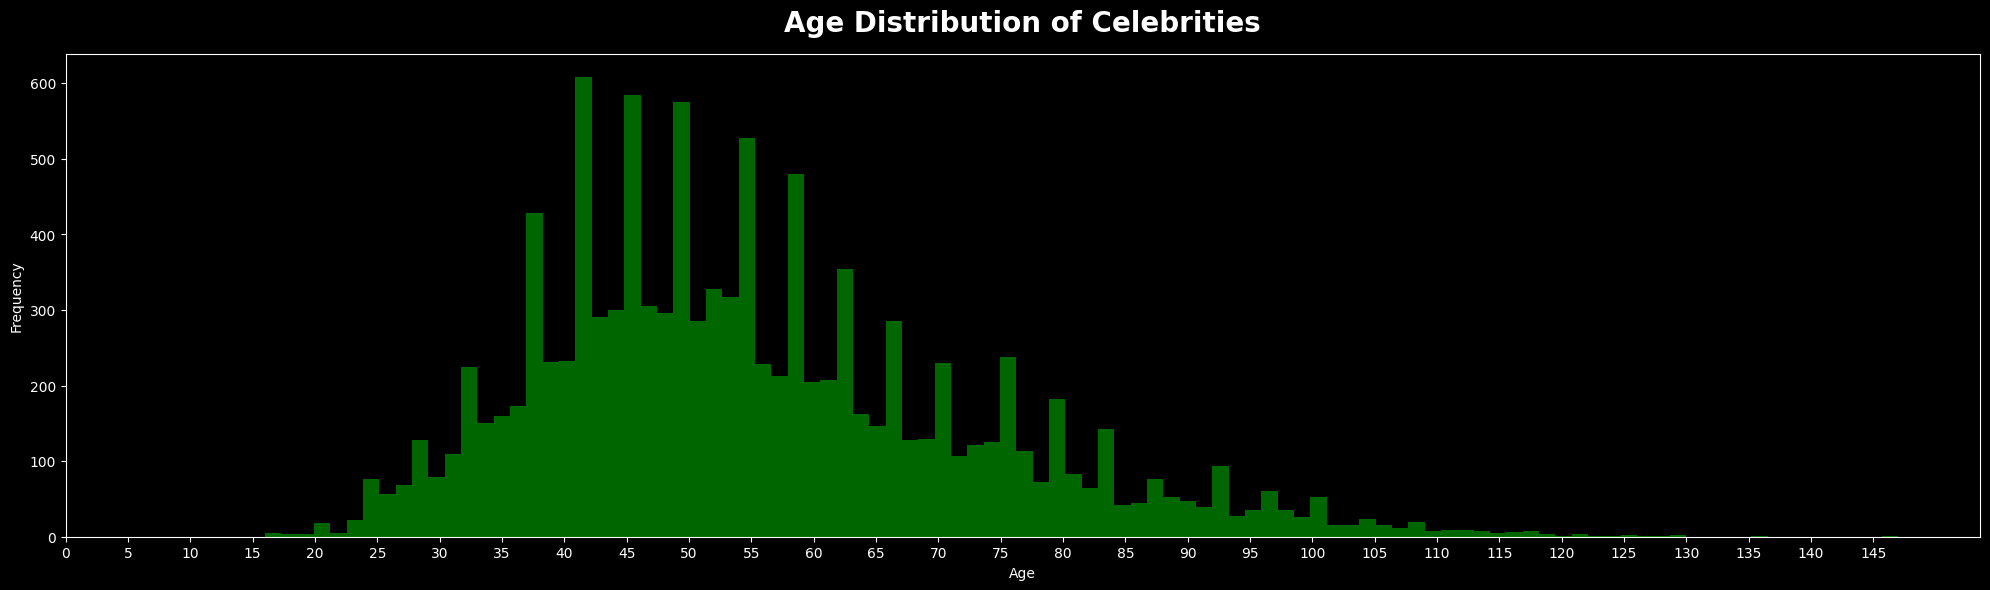

In [42]:
# Plotting the distribution of the age of the celebrities
plt.figure(figsize=(20, 6))
plt.hist(data_df["Current Age"], bins=100, color="green", alpha=0.8)
max_age = data_df["Current Age"].max()
plt.xticks(range(0, max_age, 5))
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution of Celebrities", fontsize=20, fontweight="bold", y=1.03)
plt.tight_layout()
plt.show()

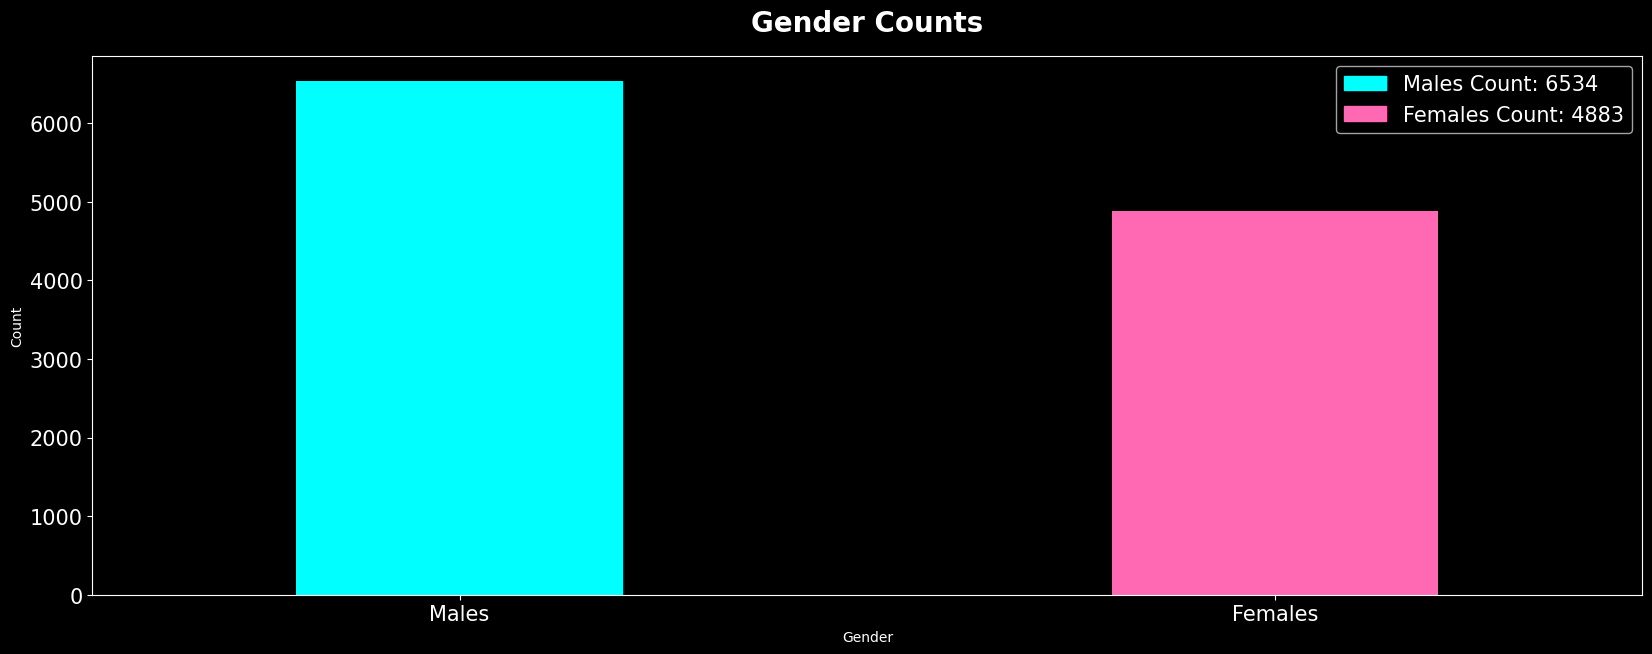

In [43]:
# Plotting the distribution genders in the celebrities dataset
gender_counts = data_df["Gender"].value_counts()
gender_counts.rename({0: "Females", 1: "Males"}, inplace=True)

plt.figure(figsize=(20, 7))
gender_counts.plot(kind="bar", color=["aqua", "hotpink"], rot=0, width=0.4)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Gender")
plt.ylabel("Count")

plt.title("Gender Counts", fontsize=20, fontweight="bold", y=1.03)

females_patch = mpatches.Patch(
    color="hotpink", label=f"Females Count: {gender_counts[1]}"
)
males_patch = mpatches.Patch(color="aqua", label=f"Males Count: {gender_counts[0]}")
plt.legend(handles=[males_patch, females_patch], fontsize=15)

plt.show()

### Bivariate Exploration <a id="bivis"></a>


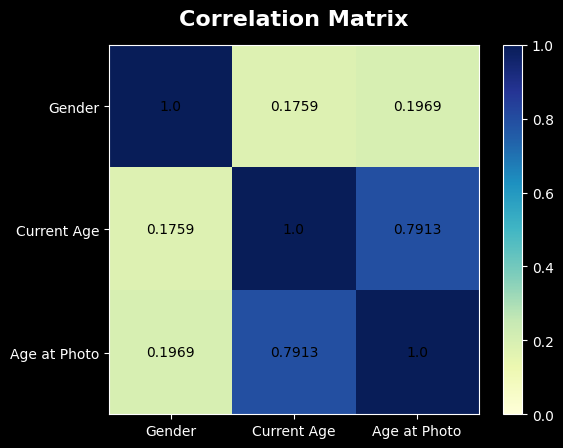

In [44]:
# Plotting the correlation matrix of the data using a heatmap
corr = data_df[["Gender", "Current Age", "Age at Photo"]].corr()
plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", y=1.03)

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

## Preprocessing Data <a id='pre'></a>


### Getting Images Pixels <a id='pix'></a>


In [45]:
# Creating a function to load the image pixels from the path
def load_imgs(path):
    return cv2.imread(dataset_path + "/imdb_crop/imdb_crop/" + path)

In [46]:
# Loading the image pixels from the path
data_df["Image Pixels"] = data_df["Full Img Path"].apply(load_imgs)

In [47]:
# Dropping the Full Img Path column
data_df.drop("Full Img Path", axis=1, inplace=True)

In [48]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels
6874,Michele Lee,0,81,62,"[[[112, 141, 155], [112, 141, 155], [113, 142,..."
8757,David Clennon,1,80,70,"[[[45, 42, 38], [46, 43, 39], [46, 43, 39], [4..."
5562,Edoardo Ballerini,1,53,32,"[[[237, 242, 251], [237, 242, 251], [238, 243,..."
1354,Ashley Greene,0,36,23,"[[[238, 239, 237], [238, 239, 237], [238, 239,..."
10117,Roy Scheider,1,91,42,"[[[133, 151, 104], [133, 151, 104], [133, 151,..."


In [49]:
# Displaying the datatype of the image pixels column
print("Datatype of the image pixels column:", type(data_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


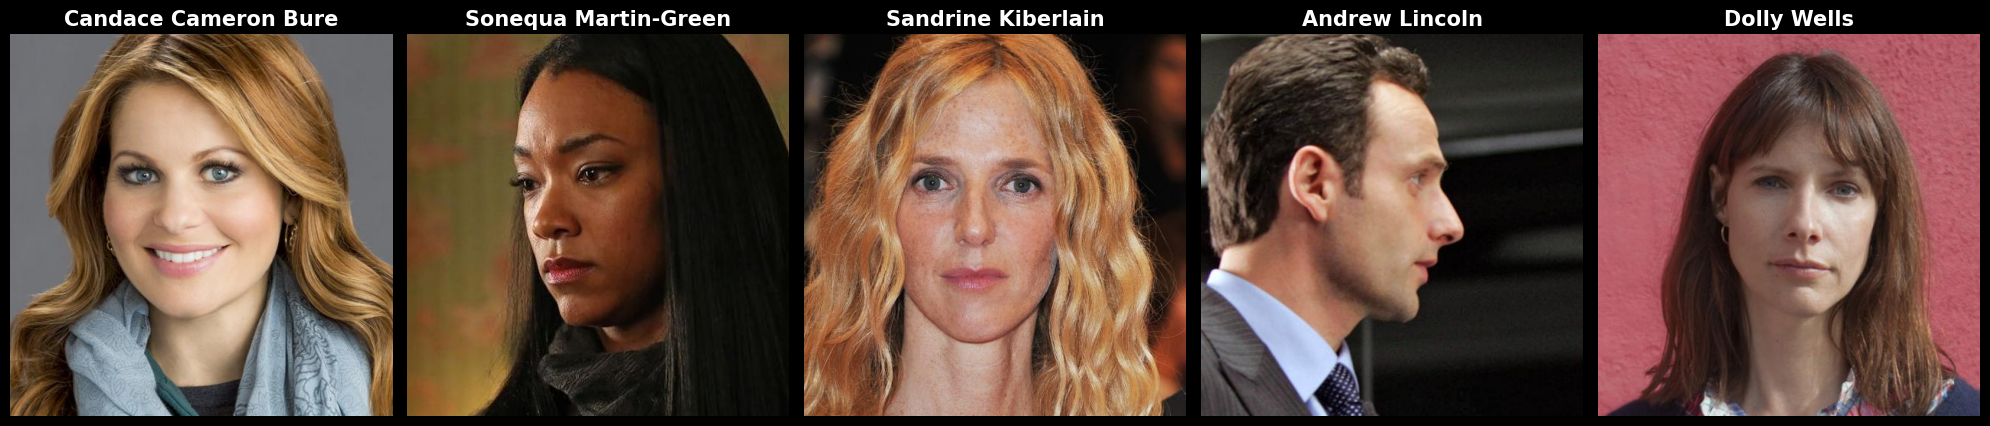

In [50]:
# Displaying the 5 random images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index
    img_pixels = data_df["Image Pixels"][random_index]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Normalizing the Images <a id='norm'></a>


In [51]:
# Creating a function to resize and normalize the image pixels
def resize_normalize_img(img):
    # resize image to 224x224
    img = cv2.resize(img, (224, 224))
    # convert image to numpy array of shape (224, 224, 3)
    img_pixels = image.img_to_array(img)
    img_pixels = np.expand_dims(img_pixels, axis=0)
    # normalize the image pixels to the range of [-1, +1]
    img_pixels /= 127.5
    img_pixels -= 1
    return img_pixels

In [53]:
# Resizing and normalizing the image pixels
data_df["Normalized Image Pixels"] = data_df["Image Pixels"].apply(resize_normalize_img)

In [56]:
# Displaying 5 random rows of the data
data_df.sample(5)

,Celebrity Name,Gender,Current Age,Age at Photo,Image Pixels,Normalized Image Pixels
9370,Eli Wallach,1,107,90,"[[[124, 138, 167], [125, 140, 172], [119, 131,...","[[[[-0.02745098 0.082353 0.30980396], [-0...."
2316,Mindy Burbano,0,55,35,"[[[20, 79, 124], [22, 77, 120], [26, 78, 115],...","[[[[-0.84313726 -0.38039213 -0.02745098], [-0...."
9506,Scott Valentine,1,65,23,"[[[168, 147, 126], [170, 149, 128], [171, 150,...","[[[[ 0.3176471 0.15294123 -0.01176471], [0.3..."
590,Katherine Heigl,0,45,30,"[[[219, 213, 224], [219, 213, 224], [219, 213,...","[[[[0.7176471 0.67058825 0.75686276], [0.7176..."
2022,Daniella Alonso,0,45,24,"[[[249, 247, 253], [252, 250, 255], [254, 253,...","[[[[0.9529412 0.9372549 0.9843137], [0.9764706..."


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


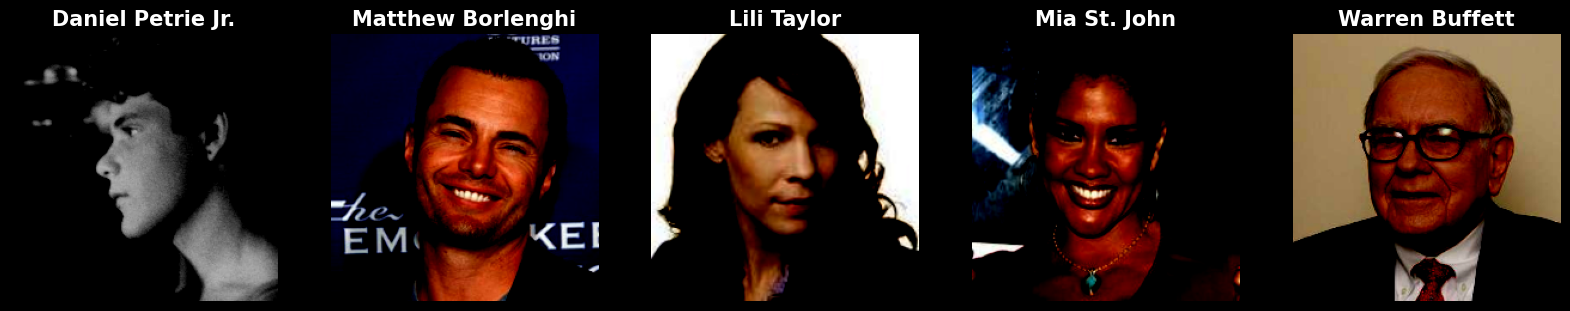

In [58]:
# Displaying the 5 random normalized images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(data_df))  # Selecting a random index
    img_pixels = data_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(data_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

In [59]:
# Showing the dimensions of the image pixels
print("Dimensions of the image pixels:", data_df["Normalized Image Pixels"][2].shape)

Dimensions of the image pixels: (1, 224, 224, 3)


## Neural Network Construction


### Building the Network
